# DAY 1

In [2]:
import os
import json
import pandas as pd
import numpy as np
import gensim.models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping

### Uploaded the 3 CSVs

In [2]:
path_reddit = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\RedditNews.csv'
path_news = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\Combined_News_DJIA.csv'
path_djia = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\upload_DJIA_table.csv'

In [3]:
reddit = pd.read_csv(path_reddit)
news = pd.read_csv(path_news)
djia = pd.read_csv(path_djia)

### Merge Dataset

In [4]:
news['Date'] = pd.to_datetime(news['Date'])
djia['Date'] = pd.to_datetime(djia['Date'])
df = news.merge(djia)

In [52]:
df.shape

(1988, 37)

### Sort out Y

In [53]:
# get percentage change
df['change'] = df['Open'].pct_change()

In [54]:
df['change'] = df['change'].shift(-1)

In [55]:
# Get categorical data
def categorical(x):
    if x > 0:
        x = 1
    else:
        x = 0
    return x

In [56]:
df['target'] = df['change'].apply(categorical)

In [57]:
# Combine the top 25 daily news into 1 column
cols = df.columns[2:]
df['combined'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [59]:
df.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Open,High,Low,Close,Volume,Adj Close,change,target,combined,cleaned
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,0.004436,1,b'Why wont America and Nato help us? If they w...,wont America Nato help u If wont help u help I...
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,-0.012637,0,b'Remember that adorable 9-year-old who sang a...,adorable sang opening ceremony That fake Georg...
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,-0.008660,0,b' U.S. refuses Israel weapons to attack Iran:...,b refuse Israel weapon attack Iran president o...


### Data Cleaning

In [9]:
from sklearn.preprocessing import FunctionTransformer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
import string
import re

In [220]:
def clean(text):
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for punctuation in punctuation:
        review1 = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    without_b=text.replace(" b ","")
    without_b=text.replace("b'","")
    without_b=text.replace('b"',"")
    tokenized = word_tokenize(without_b) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return " ".join(lemmatized)
df['cleaned'] = df['combined'].apply(clean)

In [221]:
df['cleaned'][3]

'b refuse Israel weapon attack Iran president ordered attack Tskhinvali capital South Ossetia knew doomed How come realize Israel clear troop killed Reuters policy tough drug pointless say former civil servant ran unit year old found trunk Latest ransom paid kidnapping victim Mexico Head cop quits Prez dissolve suspect elite task moved million quake survivor prefab announces Operation Get All Up In Russia Grill Yeah end well force sink Georgian ship commander Navy air reconnaissance squadron provides President defense secretary airborne ability command nation nuclear weapon relieved duty CNN reader Russia action Georgia justified send fleet Black Sea help Georgia send troop humanitarian aid exercise warns Israeli plan strike Iran nuclear facility intriguing cyberalliance two Estonian computer expert heading Georgia keep country network running amid intense military confrontation Russia CNN Effect Georgia Schools Russia Information Russias response Georgia extinct humanitarian mission s

In [63]:
df.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Open,High,Low,Close,Volume,Adj Close,change,target,combined,cleaned
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,0.004436,1,b'Why wont America and Nato help us? If they w...,wont America Nato help u If wont help u help I...
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,-0.012637,0,b'Remember that adorable 9-year-old who sang a...,adorable sang opening ceremony That fake Georg...
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,-0.008660,0,b' U.S. refuses Israel weapons to attack Iran:...,b refuse Israel weapon attack Iran president o...


### Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_bow = vectorizer.fit_transform(df.clean_text)

Some of the reviews in the dataset are too short to be considered for training. Others are too long. 

Keep only the reviews that are between 100 and 500 words.

In [122]:
def word_count(string):
    tokens = string.split()
    n_tokens = len(tokens)
    return n_tokens

df['count'] = df['cleaned'].apply(word_count)
df = df[(df['count'] > 100) & (df['count'] < 500)]

len(df) #useless cause no review with less than 100 words

1988

## Vectorizer tuning

In [123]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nb', MultinomialNB())])

parameters = {'vectorizer__ngram_range': [(1, 1),(2,2)],
              'vectorizer__max_df':[0.33,0.5,0.75],
              'vectorizer__min_df':[0.05,0.1],
              'vectorizer__max_features' : [25,50,100],
              "nb__alpha":[0.1,0.5,1]}

gridsearch = GridSearchCV(pipeline, parameters, cv=5, scoring="accuracy")

gridsearch.fit(df.cleaned, df.Label)

print( "Best score:", gridsearch.best_score_)

Best score: 0.5301823981367797


In [124]:
print( "Best parameters:", gridsearch.best_params_)  

Best parameters: {'nb__alpha': 0.1, 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 25, 'vectorizer__min_df': 0.1, 'vectorizer__ngram_range': (1, 1)}


# DAY 2

In [50]:
import gensim
from gensim.test.utils import datapath
from gensim import utils

In [51]:
import seaborn as sns

In [223]:
from sklearn.model_selection import train_test_split

X = df['cleaned']
y = df['Label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

In [227]:
type(X)

pandas.core.series.Series

In [224]:
#Tokenize the cleaned column
from gensim.utils import tokenize
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in df['cleaned']]

In [225]:
df['cleaned'][1]

'wont America Nato help u If wont help u help Iraq put foot Georgian Georgian minister Thanks Israeli training fending Russia army flees disarray Russians advance Gori abandoned Russia without shot opening ceremony firework Mossad fraudulent New Zealand Passports Iraq angered Israeli military sale American citizen living blame Georgian leader genocide innocent To World War IV Now In High Definition move mistake monumental proportion press deeper Georgia say regime change Bindra win first ever Individual Olympic Gold Medal ship head Arctic define Jerusalem taxi station threaten quit rather work new bos French Team Stunned Phelps Relay US behind Georgian aggression Do believe TV neither Russian Georgian There much victim still going Montreal Canada police murdered boy Saturday overtake US largest South Ossetia PICS Physicians Group Condemns State Russia beaten United States head Peak question Georgia Russia conflict much better come trading sex food'

In [20]:
len(sentance)

1988

In [21]:
sentance[1]

['adorable',
 'sang',
 'opening',
 'ceremony',
 'that',
 'fake',
 'georgia',
 'operation',
 'if',
 'sexual',
 'harassment',
 'would',
 'child',
 'losing',
 'support',
 'iraq',
 'brutal',
 'crackdown',
 'activity',
 'regard',
 'including',
 'woman',
 'buying',
 'cucumber',
 'georgia',
 'putin',
 'outmaneuvers',
 'microsoft',
 'intel',
 'tried',
 'kill',
 'xo',
 'the',
 'war',
 'balance',
 'power',
 'trying',
 'get',
 'sense',
 'this',
 'whole',
 'war',
 'vote',
 'up',
 'if',
 'you',
 'think',
 'georgia',
 'started',
 'it',
 'or',
 'down',
 'if',
 'think',
 'russia',
 'did',
 'us',
 'military',
 'surprised',
 'timing',
 'swiftness',
 'russian',
 'military',
 'move',
 'south',
 'ossetia',
 'still',
 'trying',
 'sort',
 'happened',
 'us',
 'defense',
 'official',
 'said',
 'monday',
 'beats',
 'war',
 'drum',
 'iran',
 'dumps',
 'georgian',
 'military',
 'attacked',
 'south',
 'ossetian',
 'capital',
 'tskhinvali',
 'multiple',
 'rocket',
 'launcher',
 'designed',
 'devastate',
 'large',
 

In [23]:
class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""

    def __iter__(self):
        for line in sentance:
            # assume there's one document per line, tokens separated by whitespace
            yield line
            
corpus = MyCorpus()

In [24]:
import gensim.models
from gensim.models import word2vec

model = gensim.models.Word2Vec(sentences=corpus)

In [25]:
print(model.wv.vocab)

{'wont': <gensim.models.keyedvectors.Vocab object at 0x0000019E8E065608>, 'america': <gensim.models.keyedvectors.Vocab object at 0x0000019E8DCDF888>, 'nato': <gensim.models.keyedvectors.Vocab object at 0x0000019E90027D48>, 'help': <gensim.models.keyedvectors.Vocab object at 0x0000019E9002B4C8>, 'u': <gensim.models.keyedvectors.Vocab object at 0x0000019E9002B508>, 'if': <gensim.models.keyedvectors.Vocab object at 0x0000019E9002B548>, 'iraq': <gensim.models.keyedvectors.Vocab object at 0x0000019E9002B588>, 'put': <gensim.models.keyedvectors.Vocab object at 0x0000019E9002B5C8>, 'foot': <gensim.models.keyedvectors.Vocab object at 0x0000019E9002B488>, 'georgian': <gensim.models.keyedvectors.Vocab object at 0x0000019E9002B3C8>, 'minister': <gensim.models.keyedvectors.Vocab object at 0x0000019E9002B608>, 'thanks': <gensim.models.keyedvectors.Vocab object at 0x0000019E9002B648>, 'israeli': <gensim.models.keyedvectors.Vocab object at 0x0000019E9002B688>, 'training': <gensim.models.keyedvectors.

In [26]:
def compute_mean_embedding(l):
    """
    l: list of words
    """
    embeddings = []
    for word in l:
        if word in model.wv:
            embeddings.append(model.wv[word])
    embeddings = np.array(embeddings)
    mean_embedding = np.mean(embeddings, axis=0)
    return mean_embedding

In [27]:
mean_vectors = []
for line in sentance:
    mean_vec = compute_mean_embedding(line)
    if mean_vec.shape != (100,):
        mean_vec= np.zeros((100,))
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)
print(mean_vectors)

[[ 5.3531483e-05 -4.0379940e-03  6.7571037e-02 ... -3.4014739e-03
   3.4141240e-01  4.6203643e-01]
 [-2.8661577e-02  2.9765695e-04  9.4799809e-02 ... -2.3518534e-02
   3.4481561e-01  4.7990686e-01]
 [-3.2467535e-03 -3.9034352e-02  4.4547621e-02 ... -8.3060965e-02
   3.3611798e-01  4.0858021e-01]
 ...
 [ 3.2304373e-02 -2.0952314e-02  1.1159199e-01 ...  8.6210612e-03
   3.1434247e-01  4.6406960e-01]
 [ 7.1759395e-02 -3.0337464e-02  1.4530420e-01 ... -1.2696328e-02
   2.7835840e-01  4.6353331e-01]
 [ 8.0864467e-02 -1.2855265e-02  1.6154502e-01 ...  7.2128056e-03
   2.6306781e-01  4.4236791e-01]]


# Approach with Train Test Split

## Train Validation Split

In [31]:
from sklearn.model_selection import train_test_split

X = df['cleaned']
y = df['Label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

In [32]:
from nltk import word_tokenize
import string

X_train_tokenized = []

for review in X_train:
    review_modified = ''.join([character for character in review if character not in string.punctuation])
    review_modified = ''.join([character for character in review_modified if not character.isdigit()])
    review_modified = review_modified.lower()
    X_train_tokenized.append(['<START>'] + word_tokenize(review_modified))

## Tokenization

In [33]:
X_val_tokenized = []

for review in X_val:
    review_modified = ''.join([character for character in review if character not in string.punctuation])
    review_modified = ''.join([character for character in review_modified if not character.isdigit()])
    review_modified = review_modified.lower()
    X_val_tokenized.append(['<START>'] + word_tokenize(review_modified))

## Rushing to a baseline with Word2Vec and mean computing

### Training the Word2Vec model

In [34]:
class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""

    def __iter__(self):
        for line in X_train_tokenized:
            # Assume there's one document per line, tokens separated by whitespace
            yield line
            
corpus = MyCorpus()

# Iterate !

In [36]:
import gensim.models
from gensim.models import word2vec

model = gensim.models.Word2Vec(sentences=corpus)

### Compute Mean Embeddings

In [37]:
def compute_mean_embedding(l):
    """
    l: list of words
    """
    embedded_l = np.array([model.wv[word] for word in l if word in model.wv.vocab.keys()])
    return embedded_l.mean(axis = 0)

In [38]:
X_train_mean_vectors = [compute_mean_embedding(review) for review in X_train_tokenized]

X_train_mean_vectors = np.array(X_train_mean_vectors)

X_train_mean_vectors.shape

(1391, 100)

In [39]:
X_val_mean_vectors = [compute_mean_embedding(review) for review in X_val_tokenized]

X_val_mean_vectors = np.array(X_val_mean_vectors)

X_val_mean_vectors.shape

(597, 100)

### Running a few classifiers as a baseline

In [41]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

ovr_log = OneVsRestClassifier(LogisticRegression(max_iter = 200))

ovr_log.fit(X_train_mean_vectors, y_train)

print(ovr_log.score(X_val_mean_vectors, y_val))

0.5527638190954773
Wall time: 43 ms


In [42]:
%%time

from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train_mean_vectors, y_train)

print(decision_tree.score(X_val_mean_vectors, y_val))

0.5309882747068677
Wall time: 247 ms


In [43]:
%%time

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

random_forest.fit(X_train_mean_vectors, y_train)

print(random_forest.score(X_val_mean_vectors, y_val))

0.5527638190954773
Wall time: 926 ms


In [61]:
%%time

from xgboost import XGBClassifier
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_mean_vectors, y_train)
print(xgboost_model.score(X_val_mean_vectors, y_val))

0.5293132328308208
Wall time: 3.13 s


# Approach with specific train/test

In [73]:
#Train data: 2008-08-08 to 2014-12-31
train_2 = df[(df['Date'] > '2008-08-08') & (df['Date'] <= '2014-12-31')]
X_train_2 = train_2['cleaned']
y_train_2 = train_2['Label']

#Test data: 2015-01-02 to 2016-07-01
test_2 = df[(df['Date'] > '2015-01-02') & (df['Date'] <= '2016-07-01')]
X_val_2 = test_2['cleaned']
y_val_2 = test_2['Label']

### Tokenization

In [74]:
from nltk import word_tokenize
import string

X_train_2_tokenized = []

for review in X_train_2:
    review_modified = ''.join([character for character in review if character not in string.punctuation])
    review_modified = ''.join([character for character in review_modified if not character.isdigit()])
    review_modified = review_modified.lower()
    X_train_2_tokenized.append(['<START>'] + word_tokenize(review_modified))

In [75]:
X_val_2_tokenized = []

for review in X_val_2:
    review_modified = ''.join([character for character in review if character not in string.punctuation])
    review_modified = ''.join([character for character in review_modified if not character.isdigit()])
    review_modified = review_modified.lower()
    X_val_2_tokenized.append(['<START>'] + word_tokenize(review_modified))

### Training the Word2Vec model

In [76]:
class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""

    def __iter__(self):
        for line in X_train_2_tokenized:
            # Assume there's one document per line, tokens separated by whitespace
            yield line
            
corpus = MyCorpus()

# Iterate !

In [77]:
import gensim.models
from gensim.models import word2vec

model_2 = gensim.models.Word2Vec(sentences=corpus)

In [78]:
def compute_mean_embedding(l):
    """
    l: list of words
    """
    embedded_l_2 = np.array([model_2.wv[word] for word in l if word in model_2.wv.vocab.keys()])
    return embedded_l_2.mean(axis = 0)

In [79]:
X_train_2_mean_vectors = [compute_mean_embedding(review) for review in X_train_2_tokenized]

X_train_2_mean_vectors = np.array(X_train_2_mean_vectors)

X_train_2_mean_vectors.shape

(1610, 100)

In [80]:
X_val_2_mean_vectors = [compute_mean_embedding(review) for review in X_val_2_tokenized]

X_val_2_mean_vectors = np.array(X_val_2_mean_vectors)

X_val_2_mean_vectors.shape

(377, 100)

### Running a few classifiers as a baseline

In [81]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

ovr_log = OneVsRestClassifier(LogisticRegression(max_iter = 200))

ovr_log.fit(X_train_2_mean_vectors, y_train_2)

print(ovr_log.score(X_val_2_mean_vectors, y_val_2))

0.506631299734748
Wall time: 41 ms


In [82]:
%%time

from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train_2_mean_vectors, y_train_2)

print(decision_tree.score(X_val_2_mean_vectors, y_val_2))

0.5013262599469496
Wall time: 171 ms


In [83]:
%%time

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

random_forest.fit(X_train_2_mean_vectors, y_train_2)

print(random_forest.score(X_val_2_mean_vectors, y_val_2))

0.47214854111405835
Wall time: 1.11 s


In [84]:
%%time

from xgboost import XGBClassifier
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_2_mean_vectors, y_train_2)
print(xgboost_model.score(X_val_2_mean_vectors, y_val_2))

0.5013262599469496
Wall time: 851 ms


## Tpot

In [85]:
# install dependencies
!pip install deap update_checker tqdm stopit joblib torch
# install xgboost optionally
!pip install xgboost
# install tpot
!pip install tpot

  ERROR: Command errored out with exit status 1:
   command: 'c:\users\henon\.venvs\lewagon\scripts\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\henon\\AppData\\Local\\Temp\\pip-install-uuq36juy\\torch\\setup.py'"'"'; __file__='"'"'C:\\Users\\henon\\AppData\\Local\\Temp\\pip-install-uuq36juy\\torch\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\henon\AppData\Local\Temp\pip-wheel-4lk2ba61'
       cwd: C:\Users\henon\AppData\Local\Temp\pip-install-uuq36juy\torch\
  Complete output (30 lines):
  running bdist_wheel
  running build
  running build_deps
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "C:\Users\henon\AppData\Local\Temp\pip-install-uuq36juy\torch\setup.py", line 265, in <module>
      description="Tensors and Dynamic neural networks in Python with s


  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11959 sha256=b18553dd671c615d011c207d7b81570e6d6d47d050bc7d11d3d0d928abe482c0
  Stored in directory: c:\users\henon\appdata\local\pip\cache\wheels\e2\d2\79\eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
  Running setup.py clean for torch
Successfully built stopit
Failed to build torch
    Running setup.py install for torch: started
    Running setup.py install for torch: finished with status 'error'


In [86]:
from sklearn.model_selection import train_test_split

X = df['cleaned']
y = df['Label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

In [219]:
X

,cleaned
0,adorable sang opening ceremony that fake georg...
1,b refuse israel weapon attack iran president o...
2,afghan prison majority female prisoner serving...
3,man arrested locked five hour taking photo pol...
4,n korea kim died replaced lookalike say waseda...
...,...
989,decriminalisation call as on drugs fails top p...
990,today the united kingdom decides whether remai...
991,scientists to australia if you want to save th...
992,explosion at airport in former president terro...


In [92]:
y

1       1
2       0
3       0
4       1
5       1
       ..
1984    0
1985    1
1986    1
1987    1
1988    1
Name: Label, Length: 1988, dtype: int64

In [93]:
from sklearn.model_selection import train_test_split
import os
from tpot import TPOTClassifier

# instanciate TPOTClassifier
tpot = TPOTClassifier(config='TPOT text', generations=5, population_size=50, verbosity=2)
# process autoML with TPOT
tpot.fit(X_train, y_train)
# print score
print(tpot.score(X_val, y_val))

TypeError: __init__() got an unexpected keyword argument 'config'

# DAY 3

In [130]:
import os
import json
import pandas as pd
import numpy as np
import gensim.models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import FunctionTransformer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
import string
import re

### Upload the 3 CSVs

In [103]:
path_reddit = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\RedditNews.csv'
path_news = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\Combined_News_DJIA.csv'
path_djia = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\upload_DJIA_table.csv'

In [104]:
reddit = pd.read_csv(path_reddit)
news = pd.read_csv(path_news)
djia = pd.read_csv(path_djia)

### Merge the CSVs

In [105]:
#merge dataset
news['Date'] = pd.to_datetime(news['Date'])
djia['Date'] = pd.to_datetime(djia['Date'])

df = news.merge(djia)

In [106]:
c

(1989, 33)

### Sort out Y

In [107]:
# get percentage change
df['change'] = df['Open'].pct_change()

In [108]:
df['change'] = df['change'].shift(-1)

In [109]:
# Get categorical data
def categorical(x):
    if x > 0:
        x = 1
    else:
        x = 0
    return x

In [110]:
df['target'] = df['change'].apply(categorical)

### Data Cleaning

In [111]:
# Combine the top 25 daily news into 1 column
cols = df.columns[2:]
df['combined'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [138]:
def clean(text):
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for punctuation in punctuation:
        review1 = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    without_b=text.replace(" b ","")
    without_b=text.replace("b'","")
    without_b=text.replace('b"',"")
    tokenized = word_tokenize(without_b) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return " ".join(lemmatized)
df['cleaned'] = df['combined'].apply(clean)

In [143]:
df['cleaned'] = df['cleaned'].str.lower() 

In [144]:
df['cleaned']

0       georgia two russian warplane country move brin...
1       wont america nato help u if wont help u help i...
2       adorable sang opening ceremony that fake georg...
3       b refuse israel weapon attack iran president o...
4       expert admit legalise drug south osetia pictur...
                              ...                        
1984    barclays rbs share suspended trading tanking s...
1985    scientists to australia if you want to save th...
1986    explosion at airport in former president terro...
1987    jamaica proposes marijuana dispenser tourist a...
1988    a woman mexico city finally received birth cer...
Name: cleaned, Length: 1989, dtype: object

## Basic Models

### Sentiment Score

#### Textblobbing

In [145]:
from textblob import TextBlob
def polarity(text):
    blob = TextBlob(text)
    polarity = blob.sentiment[0]
    return polarity

def subjectivity(text):
    blob = TextBlob(text)
    subjectivity = blob.sentiment[1]
    return subjectivity

In [146]:
# Textblob features
df['polarity'] = df['cleaned'].apply(polarity)
df['subjectivity'] = df['cleaned'].apply(subjectivity)

In [147]:
df.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Low,Close,Volume,Adj Close,change,target,combined,cleaned,polarity,subjectivity
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,11388.040039,11734.320312,212830000,11734.320312,0.026030,1,"b""Georgia 'downs two Russian warplanes' as cou...",georgia two russian warplane country move brin...,-0.045117,0.263801
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,11675.530273,11782.349609,183190000,11782.349609,0.004436,1,b'Why wont America and Nato help us? If they w...,wont america nato help u if wont help u help i...,0.084858,0.355152


### Vader Sentiment

In [148]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [149]:
test = df['cleaned'][30]

In [150]:
analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores(test)
vs

{'neg': 0.261, 'neu': 0.653, 'pos': 0.086, 'compound': -0.991}

### Data Viz

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

In [162]:
df['change'] = df['change']*100

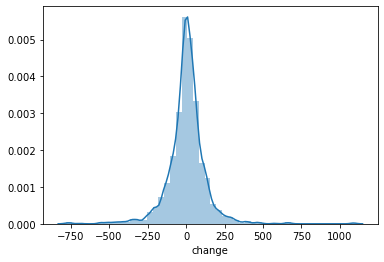

In [163]:
sns.distplot(df['change'])

In [154]:
df['change'].describe()

count    1988.000000
mean        0.030458
std         1.252307
min        -7.792702
25%        -0.443151
50%         0.055998
75%         0.565369
max        10.948993
Name: change, dtype: float64

### Define X and Y

In [265]:
# X: get a new df with only the lowest and highest 25%
big_drop = df.loc[(df['change'] <= -44.315124), 'cleaned'].to_frame()
big_inc = df.loc[(df['change'] >= 56.536893), 'cleaned'].to_frame()
X = pd.concat([big_drop,big_inc])
X.reset_index(drop=True, inplace=True)
X = X['cleaned']

In [266]:
# Y: get a new df with only the lowest and highest 25%
big_drop_Y = df.loc[(df['change'] <= -44.315124), 'Label'].to_frame()
big_inc_Y = df.loc[(df['change'] >= 56.536893), 'Label'].to_frame()
y = pd.concat([big_drop_Y,big_inc_Y])
y.reset_index(drop=True, inplace=True)
y = y['Label']

### Train Test Split

In [267]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

### Tokenization

In [268]:
from nltk import word_tokenize
import string

X_train_tokenized = []

for review in X_train:
    review_modified = ''.join([character for character in review if character not in string.punctuation])
    review_modified = ''.join([character for character in review_modified if not character.isdigit()])
    review_modified = review_modified.lower()
    X_train_tokenized.append(['<START>'] + word_tokenize(review_modified))

In [269]:
X_val_tokenized = []

for review in X_val:
    review_modified = ''.join([character for character in review if character not in string.punctuation])
    review_modified = ''.join([character for character in review_modified if not character.isdigit()])
    review_modified = review_modified.lower()
    X_val_tokenized.append(['<START>'] + word_tokenize(review_modified))

In [270]:
class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""

    def __iter__(self):
        for line in sentance:
            # assume there's one document per line, tokens separated by whitespace
            yield line
            
corpus = MyCorpus()

In [271]:
import gensim.models
from gensim.models import word2vec

model = gensim.models.Word2Vec(sentences=corpus)

In [272]:
def compute_mean_embedding(l):
    """
    l: list of words
    """
    embedded_l = np.array([model.wv[word] for word in l if word in model.wv.vocab.keys()])
    return embedded_l.mean(axis = 0)

In [273]:
X_train_mean_vectors = [compute_mean_embedding(review) for review in X_train_tokenized]

X_train_mean_vectors = np.array(X_train_mean_vectors)

X_train_mean_vectors.shape

(695, 100)

In [274]:
X_val_mean_vectors = [compute_mean_embedding(review) for review in X_val_tokenized]

X_val_mean_vectors = np.array(X_val_mean_vectors)

X_val_mean_vectors.shape

(299, 100)

### Basis Models

In [275]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

ovr_log = OneVsRestClassifier(LogisticRegression(max_iter = 200))

ovr_log.fit(X_train_mean_vectors, y_train)

print(ovr_log.score(X_val_mean_vectors, y_val))

0.47157190635451507
Wall time: 52.1 ms


In [276]:
%%time

from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train_mean_vectors, y_train)

print(decision_tree.score(X_val_mean_vectors, y_val))

0.48494983277591974
Wall time: 4.71 s


In [277]:
%%time

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

random_forest.fit(X_train_mean_vectors, y_train)

print(random_forest.score(X_val_mean_vectors, y_val))

0.42474916387959866
Wall time: 603 ms


In [278]:
%%time

from xgboost import XGBClassifier
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_mean_vectors, y_train)
print(xgboost_model.score(X_val_mean_vectors, y_val))

0.46488294314381273
Wall time: 500 ms


# New Approach

### Inspiration: https://www.youtube.com/watch?v=h-LGjJ_oANs

In [280]:
path_reddit = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\RedditNews.csv'
path_news = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\Combined_News_DJIA.csv'
path_djia = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\upload_DJIA_table.csv'

In [281]:
reddit = pd.read_csv(path_reddit)
news = pd.read_csv(path_news)
djia = pd.read_csv(path_djia)

In [282]:
#merge dataset
news['Date'] = pd.to_datetime(news['Date'])
djia['Date'] = pd.to_datetime(djia['Date'])

data = news.merge(djia)

In [286]:
# get percentage change
data['change'] = data['Open'].pct_change()

In [287]:
data['change'] = data['change'].shift(-1)

In [288]:
# Get categorical data
def categorical(x):
    if x > 0:
        x = 1
    else:
        x = 0
    return x

In [289]:
data['target'] = data['change'].apply(categorical)

In [291]:
# Combine the top 25 daily news into 1 column
cols = data.columns[2:]
data['combined'] = data[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

## Data Cleaning (step by step)

In [294]:
#Remove Punctation
import string

def remove_punctuation(text):
    for punctuation in string.punctuation: 
        text = text.replace(punctuation, ' ') 
    return text

data['combined'] = data.combined.apply(remove_punctuation)

In [296]:
#Remove uppercase
def lowercase (text): 
    lowercased = text.lower() 
    return lowercased

data['combined'] = data.combined.apply(lowercase)

In [310]:
#Remove Numbers
def remove_numbers (text):
    words_only = ''.join([i for i in text if not i.isdigit()])
    return words_only

data['combined'] = data.combined.apply(remove_numbers)

'b georgia  downs two russian warplanes  as countries move to brink of war  b breaking  musharraf to be impeached   b russia today  columns of troops roll into south ossetia  footage from fighting  youtube   b russian tanks are moving towards the capital of south ossetia  which has reportedly been completely destroyed by georgian artillery fire  b afghan children raped with  impunity   u n  official says   this is sick  a three year old was raped and they do nothing  b  russian tanks have entered south ossetia whilst georgia shoots down two russian jets   b breaking  georgia invades south ossetia  russia warned it would intervene on so s side  b the  enemy combatent  trials are nothing but a sham  salim haman has been sentenced to    years  but will be kept longer anyway just because they feel like it   b georgian troops retreat from s  osettain capital  presumably leaving several hundred people killed   video   b did the u s  prep georgia for war with russia   b rice gives green light

### Train Test Split

In [325]:
#Train data: 2008-08-08 to 2014-12-31
train = data[(data['Date'] > '2008-08-08') & (data['Date'] <= '2014-12-31')]
#Test data: 2015-01-02 to 2016-07-01
test = data[(data['Date'] > '2015-01-02') & (data['Date'] <= '2016-07-01')]

### Bag of Words

In [316]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [338]:
# Implement Bag of Words
cv = CountVectorizer(ngram_range=(2,2))
traindataset = cv.fit_transform(train['combined'])

In [339]:
rd = RandomForestClassifier(n_estimators=200, criterion='entropy')
rd.fit(traindataset, train['target'])

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [340]:
#Predict for the test dataset
test_transform = []
for row in range(0, len(test.index)):
    test_transform.append(' '.join(str(x) for x in test.iloc[row,2:27]))
test_dataset = cv.transform(test_transform)
predictions = rd.predict(test_dataset)

In [341]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [342]:
score = accuracy_score(test['target'], predictions)
print(score)

0.5119363395225465


# Mr. 0.94

In [345]:
print(data.shape)
print(data.dtypes)

(1989, 36)
Date         datetime64[ns]
Label                 int64
Top1                 object
Top2                 object
Top3                 object
Top4                 object
Top5                 object
Top6                 object
Top7                 object
Top8                 object
Top9                 object
Top10                object
Top11                object
Top12                object
Top13                object
Top14                object
Top15                object
Top16                object
Top17                object
Top18                object
Top19                object
Top20                object
Top21                object
Top22                object
Top23                object
Top24                object
Top25                object
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
Adj Close           float64
change              float64
target                int64
combined 

# DAY 4: Christophe Magic

In [2]:
# Set un the environment
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
from pandas import Series, datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns

c:\users\henon\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [6]:
path_reddit = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\RedditNews.csv'
path_news = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\Combined_News_DJIA.csv'
path_djia = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\upload_DJIA_table.csv'
combined = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\combined_stock_data.csv'

In [7]:
df_news = pd.read_csv(combined)
df_djia = pd.read_csv(path_djia)

In [8]:
df_news['Date'] = pd.to_datetime(df_news['Date'])
df_djia['Date'] = pd.to_datetime(df_djia['Date'])

In [9]:
df = df_news[['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive','Negative', 'Neutral']].merge(df_djia)

In [9]:
def categorical(x):
    if x > 0:
        x = 1
    else:
        x = 0
    return x

df['change'] = df['Open'].pct_change()
# remove first row
df['change'] = df['change'].shift(-1)
df['target'] = df['change'].apply(categorical)

In [10]:
df.index = df.index.sort_values()

In [11]:
df.head()

,Date,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,change,target
0,2008-08-08,0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,-0.244438,0
1,2008-12-08,0,56.250000,43.750000,18.750000,37.500000,43.750000,8637.650391,9026.410156,8637.490234,8934.179688,358970000,8934.179688,0.346756,1
2,2008-08-13,0,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,-0.008660,0
3,2008-08-14,1,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,0.006863,1
4,2008-08-15,1,70.000000,30.000000,10.000000,60.000000,30.000000,11611.209961,11709.889648,11599.730469,11659.900391,215040000,11659.900391,0.004172,1


## Heatmap

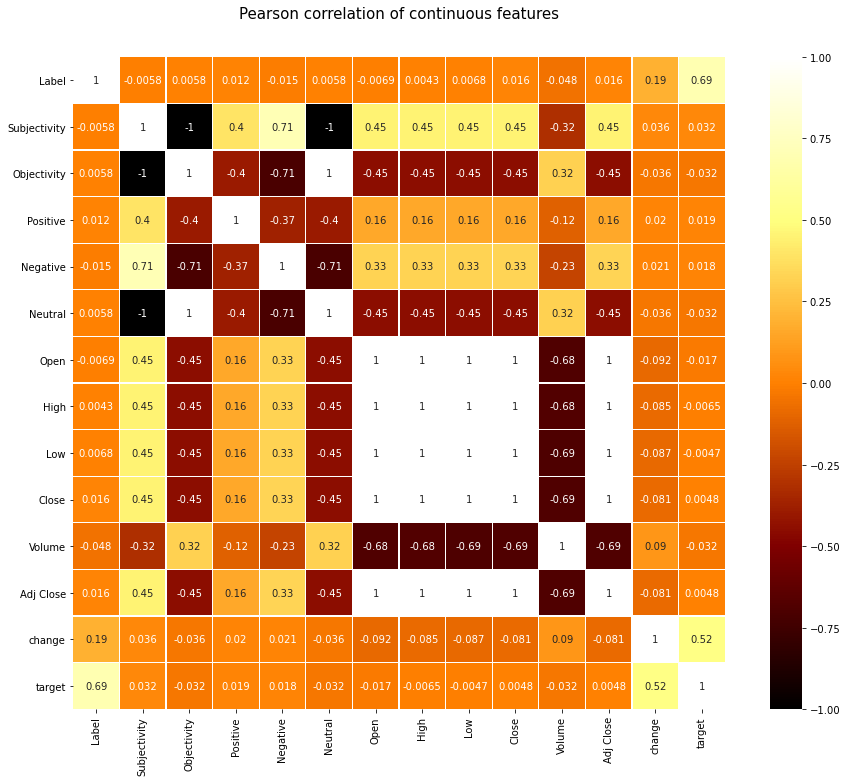

In [12]:
colormap = pyplot.cm.afmhot
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

## Data Cleaning 

In [13]:
df = df.dropna()
df.isnull().sum()

Date            0
Label           0
Subjectivity    0
Objectivity     0
Positive        0
Negative        0
Neutral         0
Open            0
High            0
Low             0
Close           0
Volume          0
Adj Close       0
change          0
target          0
dtype: int64

In [31]:
df['change'] = df['change']*100

In [14]:
y = df['target']

In [15]:
X = df.drop('Label', axis = 1)
X = X.drop('target', axis = 1)
X = X.drop('Date', axis = 1)
X = X.drop('change', axis = 1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

### Modelling 

In [18]:
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_lda.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))

accuracy score:
0.7982456140350878


### Train Test Split 2: Extreme Movements in Dow Index

In [33]:
df['change'].describe()

count    1726.000000
mean       11.493868
std       430.766171
min     -3144.984876
25%       -77.056222
50%        10.089339
75%       102.211491
max      3503.845326
Name: change, dtype: float64

In [52]:
big_drop = df[df['change'] <= -77.056222]
big_inc = df[df['change'] >= 102.211491]
X = pd.concat([big_drop,big_inc])
X.reset_index(drop=True, inplace=True)
X = X.drop('Label', axis = 1)
X = X.drop('target', axis = 1)
X = X.drop('Date', axis = 1)
X = X.drop('change', axis = 1)
X = X[['Subjectivity','Objectivity','Positive','Negative','Neutral','Open','High','Low','Close','Volume','Adj Close']]

In [53]:
# Y: get a new df with only the lowest and highest 25%
big_drop_Y = df.loc[(df['change'] <= -77.056222), 'target'].to_frame()
big_inc_Y = df.loc[(df['change'] >= 102.211491), 'target'].to_frame()
y = pd.concat([big_drop_Y,big_inc_Y])
y.reset_index(drop=True, inplace=True)
y = y['target']

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

In [56]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

ovr_log = OneVsRestClassifier(LogisticRegression(max_iter = 200))

ovr_log.fit(X_train, y_train)

print(ovr_log.score(X_val, y_val))

0.47307692307692306
Wall time: 24.5 ms


In [57]:
%%time

from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, y_train)

print(decision_tree.score(X_val, y_val))

0.6115384615384616
Wall time: 22.7 ms


In [59]:
%%time

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

print(random_forest.score(X_val, y_val))

0.6269230769230769
Wall time: 282 ms


In [60]:
%%time

from xgboost import XGBClassifier
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train)
print(xgboost_model.score(X_val, y_val))

0.6423076923076924
Wall time: 143 ms


### Train Test Split 2: Period

In [68]:
#Train data: 2008-08-08 to 2014-12-31
train = df[(df['Date'] > '2008-08-08') & (df['Date'] <= '2014-12-31')]
X_train = train[['Subjectivity','Objectivity','Positive','Negative','Neutral','Open','High','Low','Close','Volume','Adj Close']]
y_train = train['target']

#Test data: 2015-01-02 to 2016-07-01
test = df[(df['Date'] > '2015-01-02') & (df['Date'] <= '2016-07-01')]
X_test = test[['Subjectivity','Objectivity','Positive','Negative','Neutral','Open','High','Low','Close','Volume','Adj Close']]
y_test = test['target']

In [69]:
X_train.shape

(1410, 11)

In [70]:
X_test.shape

(315, 11)

In [71]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

ovr_log = OneVsRestClassifier(LogisticRegression(max_iter = 200))

ovr_log.fit(X_train, y_train)

print(ovr_log.score(X_test, y_test))

0.5238095238095238
Wall time: 18.1 ms


In [72]:
%%time

from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, y_train)

print(decision_tree.score(X_test, y_test))

0.5555555555555556
Wall time: 24 ms


In [73]:
%%time

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

print(random_forest.score(X_test, y_test))

0.5841269841269842
Wall time: 420 ms


In [74]:
%%time

from xgboost import XGBClassifier
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train)
print(xgboost_model.score(X_test, y_test))

0.5904761904761905
Wall time: 130 ms


In [76]:
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_lda.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))

accuracy score:
0.5238095238095238


### Data Exploration 

In [77]:
df.head(3)

,Date,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,change,target
0,2008-08-08,0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,-2444.381991,0
1,2008-12-08,0,56.250000,43.750000,18.750000,37.500000,43.750000,8637.650391,9026.410156,8637.490234,8934.179688,358970000,8934.179688,3467.562408,1
2,2008-08-13,0,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,-86.599250,0


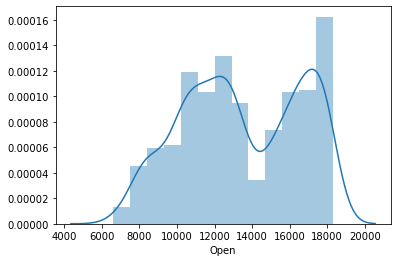

In [78]:
sns.distplot(df['Open'])

In [79]:
df['Open'].describe()

count     1726.000000
mean     13449.722832
std       3136.272017
min       6595.160156
25%      10929.785156
50%      13027.965332
75%      16459.629883
max      18315.060547
Name: Open, dtype: float64

In [80]:
df.index[df['Open']==18315.060547].tolist()

[1497]

In [82]:
df['Date'][1497]

Timestamp('2015-05-20 00:00:00')

In [141]:
data_news = pd.read_csv(combined)
data_djia = pd.read_csv(path_djia)

In [150]:
data_news['Date'] = pd.to_datetime(df_news['Date'])
data_djia['Date'] = pd.to_datetime(df_djia['Date'])

In [151]:
data_djia.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
Adj Close           float64
dtype: object

In [152]:
data_djia.head(2)

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234


In [178]:
data_news.head(2)

,Unnamed: 0,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,...,Top22,Top23,Top24,Top25,Para,Subjectivity,Objectivity,Positive,Neutral,Negative
0,0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...",...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","b""Georgia 'downs two Russian warplanes' as cou...",75.000000,25.000000,18.750000,25.000000,56.250000
1,1,2008-11-08,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",b'Why wont America and Nato help us? If they w...,83.333333,16.666667,41.666667,16.666667,41.666667


### Adding 2 columns on Dow Jones Change

In [204]:
data_djia['Day Change'] = ((data_djia['Open']-data_djia['Close'])/data_djia['Open'])*100
data_djia['2d Change'] = data_djia['Open'].pct_change(periods = 2)*100

### Merging the 2 datasets

In [205]:
data = data_news[['Date', 'Para', 'Label', 'Subjectivity', 'Objectivity', 'Positive','Negative', 'Neutral']].merge(data_djia)

In [206]:
data.head(3)

,Date,Para,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Day Change,2d Change
0,2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou...",0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,-2.643703,-2.967402
1,2008-12-08,b'Remember that adorable 9-year-old who sang a...,0,56.250000,43.750000,18.750000,37.500000,43.750000,8637.650391,9026.410156,8637.490234,8934.179688,358970000,8934.179688,-3.432986,-0.636715
2,2008-08-13,b' U.S. refuses Israel weapons to attack Iran:...,0,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0.858345,0.186024


In [207]:
data.dtypes

Date            datetime64[ns]
Para                    object
Label                    int64
Subjectivity           float64
Objectivity            float64
Positive               float64
Negative               float64
Neutral                float64
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Adj Close              float64
Day Change             float64
2d Change              float64
dtype: object

### Checking the relation between the change and the news

In [208]:
data['Day Change'].describe()

count    1730.000000
mean       -0.047970
std         1.230898
min       -10.932930
25%        -0.583037
50%        -0.072306
75%         0.437669
max         7.783348
Name: Day Change, dtype: float64

### Explore the Max Value of 2d Change

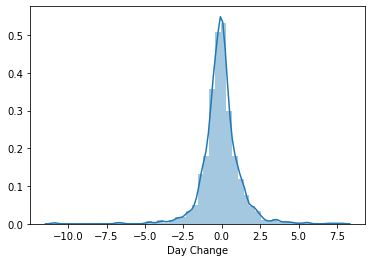

c:\users\henon\.venvs\lewagon\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


[]

In [154]:
data_news['Para'][1]

'b\'Why wont America and Nato help us? If they wont help us now, why did we help them in Iraq?\'b\'Bush puts foot down on Georgian conflict\'b"Jewish Georgian minister: Thanks to Israeli training, we\'re fending off Russia "b\'Georgian army flees in disarray as Russians advance - Gori abandoned to Russia without a shot fired\'b"Olympic opening ceremony fireworks \'faked\'"b\'What were the Mossad with fraudulent New Zealand Passports doing in Iraq?\'b\'Russia angered by Israeli military sale to Georgia\'b\'An American citizen living in S.Ossetia blames U.S. and Georgian leaders for the genocide of innocent people\'b\'Welcome To World War IV! Now In High Definition!\'b"Georgia\'s move, a mistake of monumental proportions "b\'Russia presses deeper into Georgia; U.S. says regime change is goal\'b\'Abhinav Bindra wins first ever Individual Olympic Gold Medal for India\'b\' U.S. ship heads for Arctic to define territory\'b\'Drivers in a Jerusalem taxi station threaten to quit rather than wor

In [155]:
data = data_news[['Date', 'Label', 'Para', 'Subjectivity', 'Objectivity', 'Positive','Negative', 'Neutral']].merge(data_djia)

In [156]:
data.head(2)

,Date,Label,Para,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",75.00,25.00,18.75,56.25,25.00,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1,2008-12-08,0,b'Remember that adorable 9-year-old who sang a...,56.25,43.75,18.75,37.50,43.75,8637.650391,9026.410156,8637.490234,8934.179688,358970000,8934.179688


In [157]:
data['Open'].describe()

count     1730.000000
mean     13447.200652
std       3135.993006
min       6595.160156
25%      10920.662842
50%      13026.960450
75%      16459.629883
max      18315.060547
Name: Open, dtype: float64

## Maximum Value of the Dow Jones on the 20th of May 2015

In [158]:
data.index[data['Open']==18315.060547].tolist()

[1497]

In [159]:
data['Date'][1497]

Timestamp('2015-05-20 00:00:00')

In [160]:
data['Para'][1497]

'Banks fined $5.7bn over foreign exchange rigging - live updates | Regulators are announcing penalties against some of the worlds biggest banks for their role in manipulating the foreign exchange markets.U.S. Central Intelligence Agency leaked propaganda material to the producers of \'Zero Dark Thirty\' to build a positive spin on torture programmesIrans Supreme Leader Ayatollah Ali Khamenei has ordered that all Afghan children in Iran be permitted schooling regardless of their residency status. This decision impacts hundreds of thousands of children and can help improve the precarious status of the approximately 3 million Afghans in Iran.Obama is creating a 1,500-mile butterfly corridor to help Monarchs get from Mexico to MinnesotaJapanese air bag manufacturer Takata Corp. will announce it is declaring an estimated 33.8 million vehicles defective, a move that is expected to lead to the largest auto recall in U.S. historyNew Australian laws could criminalise the teaching of encryption1

## Minimum Value of the Dow

In March 2009, it seemed as if nothing could stop the plummeting stock market as U.S. investors feared the entire banking industry was on the brink of collapse. The largest U.S. banks had been bailed out by the government via the Troubled Assets Relief Program, and investors struggled to understand just how bad the situation was.
https://www.benzinga.com/general/education/19/03/11312055/this-day-in-market-history-dow-hits-2009-financial-crisis-low

In [161]:
data.index[data['Open']==6595.160156].tolist()

[170]

In [162]:
data['Date'][170]

Timestamp('2009-03-06 00:00:00')

In [165]:
record_low_info = data['Para'][169]
record_low_info

'b\'Jaqui Smith finally fucking off, civil rights has a small respite and breathes a sigh of relief\'b\'Life expectancy Vs Income/person across the world over 2 centuries [map]\'b"To understand how North Korea has come up with the money to finance its missile-and-nuclear-weapons program, it\'s important to realize that Koreans haven\'t been living in caves for the past 2 decades."b\'Dutch journalist is kidnapped by Talibans who rape her repeatedly. Her comments about the Taliban: "They also respected me", "They are not monsters", "... could not control his testosterone". A story about Stockholm syndrome and the politically correct.\'b\'Why the Air France plane crashed: Salon\\\'s "Ask the Pilot" explains the possibilities\'b\'A quick fix for up to half of all child deaths?\'b\'Mexico detains 25 police officers for alleged ties to drug traffickers\'b\'Kazakhstan\\\'s former head of state nuclear power agency "stole" over 60% of the countries Uranium!\'b\'Public believe politicians are c

In [118]:
from collections import Counter

In [121]:
split_it = record_low_info.split() 

In [122]:
Counter = Counter(split_it) 

In [125]:
most_occur = Counter.most_common(20)

In [126]:
print(most_occur) 

[('the', 21), ('to', 12), ('of', 11), ('a', 8), ('for', 8), ('in', 6), ('and', 5), ('on', 4), ('he', 4), ('North', 3), ('with', 3), ('that', 3), ('about', 3), ('not', 3), ('his', 3), ('US', 3), ('has', 2), ('world', 2), ('over', 2), ('2', 2)]


In [137]:
data.dtypes

Date            datetime64[ns]
Label                    int64
Para                    object
Subjectivity           float64
Objectivity            float64
Positive               float64
Negative               float64
Neutral                float64
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Adj Close              float64
dtype: object

### Data Explo from scratch

In [4]:
df_news = pd.read_csv(combined)
df_djia = pd.read_csv(path_djia)

NameError: name 'combined' is not defined

In [5]:
df_news['Date'] = pd.to_datetime(df_news['Date'])
df_djia['Date'] = pd.to_datetime(df_djia['Date'])

NameError: name 'df_news' is not defined

In [280]:
df_djia["Day Change"] = df_djia["Day Change"].dropna()
df_djia["Day Change"] = df_djia["Day Change"].round(2)
df_djia["2d Change"] = df_djia["2d Change"].dropna()
df_djia["2d Change"] = df_djia["2d Change"].round(2)

In [254]:
df_djia.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Day Change,2d Change
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,-0.14,NaN
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,-1.23,NaN
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,-1.37,-2.612221
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,-1.28,-2.948439
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,1.24,-0.577500


### Maximum change in One Day

In [256]:
df_djia['Day Change'].max()

7.78

In [257]:
df_djia[df_djia['Day Change']==7.78]

,Date,Open,High,Low,Close,Volume,Adj Close,Day Change,2d Change
1941,2008-10-15,9301.910156,9308.759766,8530.120117,8577.910156,374350000,8577.910156,7.78,3.638416


In [271]:
worst_news = df_news[df_news['Date']=='2008-10-15']

**News on the Day Day Change on the 15th of October 2008:**                                                                
b'On behalf of the 64% of Canadians who did not vote for our new Conservative government, I apologize for what our country has done.'b"China will be a democracy by 2020, according to one of the country's most influential reformers. "b"Iceland: Britain's unlikely new enemy"b'CFR Member Calls For New Global Monetary Authority'b'How to engineer a financial catastrophe.'b'Suicide spurs bid to regulate the Internet in South Korea'b'Australia: Muslim Students Group Outraged After Having to Share Prayer Room With Infidels'b'President of Honduras Calls for Drug Legalization'b'Conservative government re-elected, CBC projects'b"Rabbits Overrun Nelson Mandela's Jail of 18 Years"b'Thai and Cambodian soldiers fire bullets and rocket-propelled grenades at one another over disputed border two days after Cambodia warned of potential "large-scale conflict".'b'CNN: Re-election Projected for Canadian PM Stephen Harper'b'Brazil saves penguins. Yay for penguins!'b"Muslim convert Joseph Thomas took ticket, cash from al-Qa'ida: court"b"Canada's vote against change"b'...a Saudi woman initiated a boycott campaign against lingerie stores aiming to put pressure on shop owners to replace salesmen with women.'b'Iceland receiving assistance from Nordic countries | from the hip'b'Supreme Court Rejects Execution Appeal - NYTimes.com'b'I revealed myself to Abraham, to Isaac, and to Jacob as l Shaddi, but was NOT known to them by my name Yahweh.'b"Italians are up on arms over France's refusal to extradite for trial Marina Petrella, a former member of the communist terrorist group Brigate Rosse."b'UK Says Rich Nations Should Pay Billions Every Year for Rainforest'b'What does the rehabilitation of Bill Ayers tells us about the war on terrorism?'b'Why No Outrage Over Persecuted Hindus? How many millions of Hindus do Muslims have to kill or displace before the world takes notice? 'b'Attack on U.S. Embassy in Yemen Linked to Mossad'b"French authorities investigate the alleged posioning of a prominent Russian human rights lawyer, raising the spectre of ex-KGB officer's poisoning two years ago."

### Minimum Day Change Value

In [273]:
df_djia['Day Change'].min()

-10.93

In [274]:
df_djia[df_djia['Day Change']==-10.93]

,Date,Open,High,Low,Close,Volume,Adj Close,Day Change,2d Change
1943,2008-10-13,8462.419922,9427.990234,8462.179688,9387.610352,399290000,9387.610352,-10.93,-9.024923


In [277]:
worst_news = df_news[df_news['Date']=='2008-10-15']

**News on the Worst Day Change on the 13th of October 2008:**                                                                   b'On behalf of the 64% of Canadians who did not vote for our new Conservative government, I apologize for what our country has done.'b"China will be a democracy by 2020, according to one of the country's most influential reformers. "b"Iceland: Britain's unlikely new enemy"b'CFR Member Calls For New Global Monetary Authority'b'How to engineer a financial catastrophe.'b'Suicide spurs bid to regulate the Internet in South Korea'b'Australia: Muslim Students Group Outraged After Having to Share Prayer Room With Infidels'b'President of Honduras Calls for Drug Legalization'b'Conservative government re-elected, CBC projects'b"Rabbits Overrun Nelson Mandela's Jail of 18 Years"b'Thai and Cambodian soldiers fire bullets and rocket-propelled grenades at one another over disputed border two days after Cambodia warned of potential "large-scale conflict".'b'CNN: Re-election Projected for Canadian PM Stephen Harper'b'Brazil saves penguins. Yay for penguins!'b"Muslim convert Joseph Thomas took ticket, cash from al-Qa'ida: court"b"Canada's vote against change"b'...a Saudi woman initiated a boycott campaign against lingerie stores aiming to put pressure on shop owners to replace salesmen with women.'b'Iceland receiving assistance from Nordic countries | from the hip'b'Supreme Court Rejects Execution Appeal - NYTimes.com'b'I revealed myself to Abraham, to Isaac, and to Jacob as l Shaddi, but was NOT known to them by my name Yahweh.'b"Italians are up on arms over France's refusal to extradite for trial Marina Petrella, a former member of the communist terrorist group Brigate Rosse."b'UK Says Rich Nations Should Pay Billions Every Year for Rainforest'b'What does the rehabilitation of Bill Ayers tells us about the war on terrorism?'b'Why No Outrage Over Persecuted Hindus? How many millions of Hindus do Muslims have to kill or displace before the world takes notice? 'b'Attack on U.S. Embassy in Yemen Linked to Mossad'b"French authorities investigate the alleged posioning of a prominent Russian human rights lawyer, raising the spectre of ex-KGB officer's poisoning two years ago."

### Maximum change in One Day

In [287]:
df_djia['2d Change'].max()

11.5

In [293]:
df_djia[df_djia['2d Change']==11.5]

,Date,Open,High,Low,Close,Volume,Adj Close,Day Change,2d Change
1916,2008-11-19,8420.69043,8504.639648,7987.080078,7997.279785,350470000,7997.279785,5.03,11.5


In [298]:
best_news_2d = df_news[df_news['Date']=='2008-11-18']

**News on the Best Day Change on the 18th of November 2008:**
b'India sinks Somali pirate ship'b'New prostitution laws in the UK mean men who pay to have sex with trafficked women may face rape charges, and ignorance is no defense.'b'Finally someone steps up to Somali pirates: INDIA sinks pirate "mother ship"'b'Israel boycotts UN racism conference, claims bias'b"Egypt and Israel were at war. Anwar Sadat, Egypt's President, flew to Jerusalem to make peace. His plane door opened. Israel stood still. Israeli buglers sounded the salute. An unforgettable moment."b'After a mere four years, Ireland plans to reinstate a ban on handguns.'b'With no money, Pakistan moms abandon kids'b'Somali pirates transform villages into boomtowns - building sprawling stone McMansions'b'British and American military secrets may have been passed to the Russians by a double agent -- biggest spy scandal since CIA traitor Aldrich Ames'b'Israel slams UN call to end blockade'b"Forget Red vs. Blue -- It's the Educated vs. People Easily Fooled by Propaganda"b'The Government of Israel continues to act recklessly, and with utter disregard for the human rights of the Palestinian people, including their right to life and safety.'b'A 26-year-old flight student is dead after a propeller accident'b'The British National Party (BNP) membership list which has been published online by an ex-member can be found here'b'IRAQ WAR ENDS'b'UN Calls For End To Israeli Blockade Of Gaza Strip'b'IAEA: Bombed Syrian site had features like a nuclear reactor'b'"Today we have around 1.8 million (reported) cases of Police Torture Each Year in India. Those Tortured are generally the (Low-Caste) Dalits, the Tribals and the Muslims.'b'Well, well. Blackwater wants to fight pirates now. How unexpected.'b'early thaw in the coming cold war? Moscow reaches out to Obama on missiles'b'Pirates strike again, seize Hong Kong grain ship bound for Iran'b'More challenges to secret copyright treaty'b'WTF? Barack Obama Faces Charges in Memphis 'b"spy called 'The Spaniard' may have betrayed British and U.S. secrets to Russia for more than a decade"b'UK government unveils plan for sex trade crackdown'

### Minimum 2-Day Change Value

In [281]:
df_djia['2d Change'].min()

-10.57

In [291]:
df_djia[df_djia['2d Change']==-10.57]

,Date,Open,High,Low,Close,Volume,Adj Close,Day Change,2d Change
1914,2008-11-21,7552.370117,8071.75,7449.379883,8046.419922,569010000,8046.419922,-6.54,-10.57


In [301]:
worst_news_2d = df_news[df_news['Date']=='2008-11-20']

**News on the Worst 2d Change on the 20th of November 2008:**
b'Denmark considers outlawing male circumcision on minors.'b'Russian scholar: "Our people are much more nationalistic, much more chauvanistic, and anti-democratic than Putin himself, so the current regime is by no means the worst that we could have." (AUDIO)'b'Family makes 200K a year and gives most of it away'b'Week End Picnic: Families Slaughtered by Israel on Gaza Beach'b'Children are dying in Haiti, victims of food crisis'b"Radio host shocked as woman admits eating 'little black girls'"b'The U.S. Department of Energys National Renewable Energy Laboratory (NREL) and Petrleo Brasileiro S.A. (Petrobras) to Commercialize Biofuels'b"More Than 1/3 of China's Land is Being Scoured by Erosion! Food Supplies at Risk!"b"What's the most generous nation in humanitarian donations in relation to GNP? Surprise! It's Saudi Arabia. US and England don't even hit the top 5."b' Russian parliament approves extension of presidential term'b'Al-Jazeera editorial wonders why Western diplomats are such slow learners'b'Russian Duma passes reform to extend presidency to 6 years. Welcome back, Comrade Putin?'b'Germany Drops Attempt to Ban Scientology'b' French Socialists in run-off vote'b'Poland: Picketing hospital workers call for turning hospitals into cooperatives instead of traditional privatization'b'Russia set to extend presidential term'b"US global dominance 'set to wane'"b'UN should suspend Israel membership: Nobel Laureate Maguire'b'World struggles to take on plague of Somali piracy'b"Slump in stockmarkets wipes out two-thirds of China's billionaires"b'Cholera outbreak strikes Zimbabwe'b'What is the value of 500 Rs for different people in India or rather the World'b'billionaires body stolen'b'How the Allied multinationals supplied Nazi Germany throughout World War II'b'ATTN: RIAA/MPAA: This is piracy.'

In [309]:
Y2008 = df[(df['Date']>='2008-01-01')&(df['Date']<='2008-12-31')]
len(Y2008)

76

Text(0.5, 1.0, 'Dow Jones Evolution from 2008 to 2016')

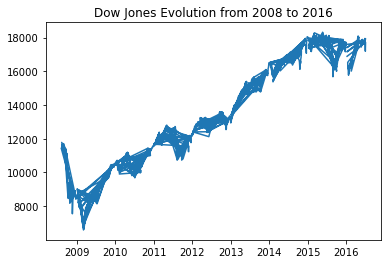

In [10]:
plt.plot(df['Date'],df['Open'])
plt.title('Dow Jones Evolution from 2008 to 2016')

In [12]:
sns.distplot(df['Open'], x_vars=['sepal_length', 'sepal_width'],y_vars=['petal_width'])

TypeError: distplot() got an unexpected keyword argument 'x_vars'

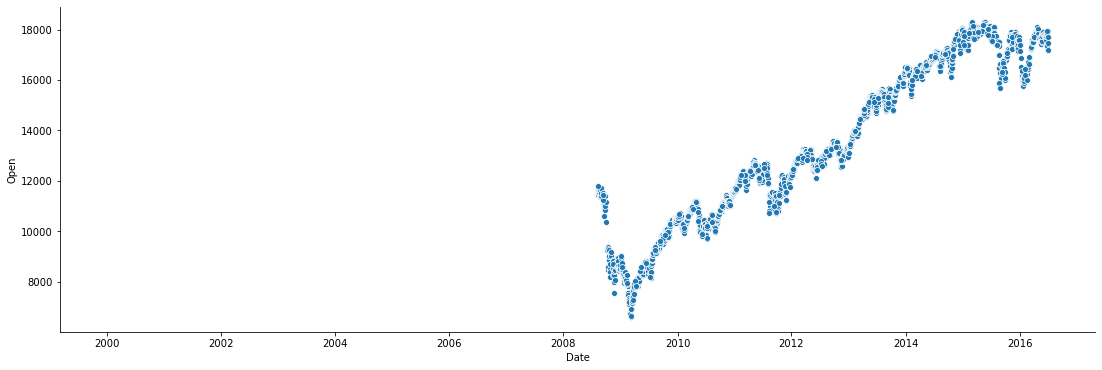

In [28]:
sns.pairplot(df, x_vars=['Date'], y_vars=['Open'], height=5, aspect=3)


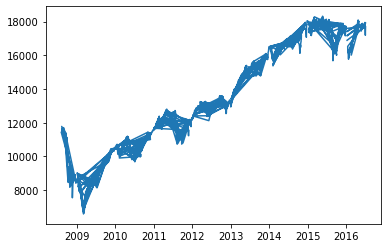

In [38]:
plt.plot(df['Date'],df['Open'])

Text(0, 0.5, 'Dow Jow Index')

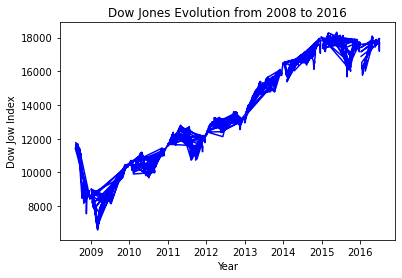

In [50]:
# YOUR PLOT HERE
x = df['Date']
y = df['Open']
plt.plot(x,y,color = 'b')
plt.plot(figsize=(30,30))
plt.title('Dow Jones Evolution from 2008 to 2016')
plt.xlabel('Year')
plt.ylabel('Dow Jow Index')

<Figure size 64800x2160 with 0 Axes>

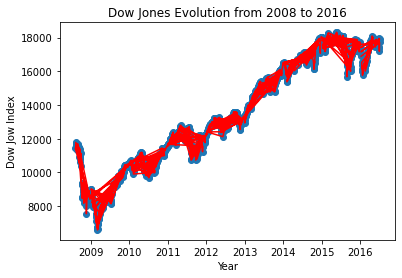

<Figure size 64800x2160 with 0 Axes>

In [72]:
# YOUR PLOT HERE
x = df['Date']
y = df['Open']
plt.scatter(x,y)
plt.plot(x, y, 'k-', color = 'r')
plt.title('Dow Jones Evolution from 2008 to 2016')
plt.xlabel('Year')
plt.ylabel('Dow Jow Index')
plt.figure(figsize=(900,30))

(array([ 27., 132., 102., 248., 217., 252.,  66., 145., 249., 292.]),
 array([ 6595.160156 ,  7767.1501951,  8939.1402342, 10111.1302733,
        11283.1203124, 12455.1103515, 13627.1003906, 14799.0904297,
        15971.0804688, 17143.0705079, 18315.060547 ]),
 <a list of 10 Patch objects>)

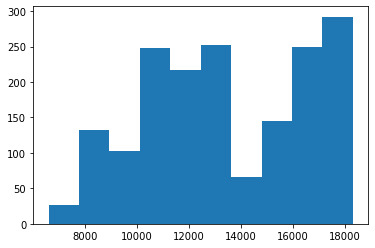

In [62]:
x = df['Date']
y = df['Open']
plt.hist(y)